In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embeddings(texts):
    # Tokenize and encode text using batch_encode_plus
    encoding = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        add_special_tokens=True
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Generate embeddings using BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Extract the [CLS] token embeddings (sentence embeddings)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]

    return embeddings

# Load CSV file into a DataFrame
df = pd.read_excel('/content/HespressANDMwnCombined.xlsx', index_col='Date')

# Ensure 'combined_text' is the name of your text column in the CSV file
text_column = df['combined_text'].tolist()

# Generate embeddings for the text column
embeddings = get_embeddings(text_column)

# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame(embeddings.numpy(), index=df.index)  # Add index for later grouping

# Add embeddings to the original DataFrame
df_embeddings = pd.concat([df, embeddings_df], axis=1)

# Group by Date and calculate the mean of embeddings
def average_embeddings(embeddings):
    return np.mean(embeddings, axis=0)

# Group by date and compute mean embeddings
grouped = df_embeddings.groupby(df_embeddings.index)
mean_embeddings = grouped.apply(lambda x: average_embeddings(x.iloc[:, -768:].values))  # Assuming 768 is the embedding size

# Convert mean embeddings to DataFrame
mean_embeddings_df = pd.DataFrame(mean_embeddings.tolist(), index=mean_embeddings.index, columns=[f'embedding_{i}' for i in range(768)])

# Merge mean embeddings with the original DataFrame (excluding the old embeddings)
df = df.drop(columns=df.columns[-768:]).join(mean_embeddings_df)

# Save the updated DataFrame to a new file (optional)
df.to_csv('/content/MWNDATA_with_mean_embeddings.csv', index=True)

# Display the updated DataFrame
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

            embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
Date                                                                          
2024-01-01     -0.33438     0.051553     0.039979    -0.243819    -0.392696   
2024-01-01     -0.33438     0.051553     0.039979    -0.243819    -0.392696   
2024-01-01     -0.33438     0.051553     0.039979    -0.243819    -0.392696   
2024-01-01     -0.33438     0.051553     0.039979    -0.243819    -0.392696   
2024-01-01     -0.33438     0.051553     0.039979    -0.243819    -0.392696   

            embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
Date                                                                          
2024-01-01     0.027876      0.51936     0.726154    -0.560388    -0.149177   
2024-01-01     0.027876      0.51936     0.726154    -0.560388    -0.149177   
2024-01-01     0.027876      0.51936     0.726154    -0.560388    -0.149177   
2024-01-01     0.027876      0.51936     0.726154  

In [ ]:
df = df.drop_duplicates()

In [ ]:
# Define the full date range you want to cover
full_date_range = pd.date_range(start='2024-01-01', end='2024-07-30', freq='D')

# Reindex the DataFrame to include all dates
df_daily = df.reindex(full_date_range)

# Fill missing values (choose the method that fits your use case)
df_daily = df_daily.interpolate(method='linear')  # Interpolation

# Reset index to turn 'Date' back into a column if needed
df_daily.reset_index(inplace=True)
df_daily.rename(columns={'index': 'Date'}, inplace=True)

In [ ]:
df_daily = df_daily[~df_daily['Date'].dt.month.isin([1,7])]

In [ ]:
df_daily = df_daily.set_index('Date')

In [ ]:
df_daily.columns

Index(['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3',
       'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7',
       'embedding_8', 'embedding_9',
       ...
       'embedding_758', 'embedding_759', 'embedding_760', 'embedding_761',
       'embedding_762', 'embedding_763', 'embedding_764', 'embedding_765',
       'embedding_766', 'embedding_767'],
      dtype='object', length=768)

In [ ]:
pivot_df = pd.read_excel('/content/pivot_df.xlsx')

In [ ]:
pivot_df = pivot_df.reset_index()

# Rename the 'index' column to 'Date'
pivot_df.rename(columns={'date': 'Date'}, inplace=True)

# Optionally, set 'Date' as the index again
pivot_df.set_index('Date', inplace=True)

In [ ]:
pivot_df = pivot_df.drop(columns=['index'])

In [ ]:
merged_df = pd.merge(pivot_df, df_daily, on='Date', how='left')

In [ ]:
from sklearn.decomposition import PCA

# Assuming your merged DataFrame is named 'merged_df'
# Extract the BERT embeddings columns (768 dimensions)
bert_embeddings = merged_df.loc[:, 'embedding_0':'embedding_767'].values

In [ ]:
# Specify the number of components you want to reduce to, e.g., 50
n_components = 25

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit and transform the embeddings
reduced_embeddings = pca.fit_transform(bert_embeddings)

# Convert the reduced embeddings back to a DataFrame
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, index=merged_df.index,
                                     columns=[f'pca_embedding_{i}' for i in range(n_components)])

In [ ]:
# Drop the original 768 embeddings from the DataFrame
merged_df_reduced = merged_df.drop(columns=[f'embedding_{i}' for i in range(768)])

# Add the reduced PCA embeddings to the DataFrame
merged_df_reduced = pd.concat([merged_df_reduced, reduced_embeddings_df], axis=1)

# Now your DataFrame 'merged_df_reduced' has the reduced embeddings
print(merged_df_reduced.head())

            Holiday_CASABLANCA  Holiday_FES  Holiday_MARRAKECH  \
Date                                                             
2024-02-01                   0            0                  0   
2024-02-02                   0            0                  0   
2024-02-03                   0            0                  0   
2024-02-04                   0            0                  0   
2024-02-05                   0            0                  0   

            Holiday_MEKNES  Holiday_OUJDA ANGAD  Holiday_RABAT  \
Date                                                             
2024-02-01               0                    0              0   
2024-02-02               0                    0              0   
2024-02-03               0                    0              0   
2024-02-04               0                    0              0   
2024-02-05               0                    0              0   

            Holiday_TANGER ASSILAH  cong_ratio_CASABLANCA  cong_ratio_FES 

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{data.columns[j]}(t-{i})') for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{data.columns[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{data.columns[j]}(t+{i})') for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

supervised_data = series_to_supervised(merged_df_reduced, n_in=5, n_out=1)

In [ ]:
supervised_data.to_excel('supervised_data.xlsx')

In [ ]:
# Get columns that contain 'cong' in their names
cong_columns = [col for col in supervised_data.columns if 'cong' in col.lower()]

# Display the columns
print(cong_columns)
target_columns = [
    'cong_ratio_CASABLANCA(t)', 'cong_ratio_FES(t)',
    'cong_ratio_MARRAKECH(t)', 'cong_ratio_MEKNES(t)',
    'cong_ratio_OUJDA ANGAD(t)', 'cong_ratio_RABAT(t)','cong_ratio_TANGER ASSILAH(t)'
]

X = supervised_data.drop(target_columns, axis=1)
y = supervised_data[target_columns]

['cong_ratio_CASABLANCA(t-5)', 'cong_ratio_FES(t-5)', 'cong_ratio_MARRAKECH(t-5)', 'cong_ratio_MEKNES(t-5)', 'cong_ratio_OUJDA ANGAD(t-5)', 'cong_ratio_RABAT(t-5)', 'cong_ratio_TANGER ASSILAH(t-5)', 'cong_ratio_CASABLANCA(t-4)', 'cong_ratio_FES(t-4)', 'cong_ratio_MARRAKECH(t-4)', 'cong_ratio_MEKNES(t-4)', 'cong_ratio_OUJDA ANGAD(t-4)', 'cong_ratio_RABAT(t-4)', 'cong_ratio_TANGER ASSILAH(t-4)', 'cong_ratio_CASABLANCA(t-3)', 'cong_ratio_FES(t-3)', 'cong_ratio_MARRAKECH(t-3)', 'cong_ratio_MEKNES(t-3)', 'cong_ratio_OUJDA ANGAD(t-3)', 'cong_ratio_RABAT(t-3)', 'cong_ratio_TANGER ASSILAH(t-3)', 'cong_ratio_CASABLANCA(t-2)', 'cong_ratio_FES(t-2)', 'cong_ratio_MARRAKECH(t-2)', 'cong_ratio_MEKNES(t-2)', 'cong_ratio_OUJDA ANGAD(t-2)', 'cong_ratio_RABAT(t-2)', 'cong_ratio_TANGER ASSILAH(t-2)', 'cong_ratio_CASABLANCA(t-1)', 'cong_ratio_FES(t-1)', 'cong_ratio_MARRAKECH(t-1)', 'cong_ratio_MEKNES(t-1)', 'cong_ratio_OUJDA ANGAD(t-1)', 'cong_ratio_RABAT(t-1)', 'cong_ratio_TANGER ASSILAH(t-1)', 'cong_rat

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaling features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

# Scaling targets
target_scaler = MinMaxScaler()
scaled_targets = target_scaler.fit_transform(y)
scaled_y_df = pd.DataFrame(scaled_targets, index=y.index, columns=y.columns)

In [ ]:
import numpy as np

def reshape_for_lstm(X, y, seq_length):
    num_samples = X.shape[0]
    num_features = X.shape[1]

    y_adjusted = y.iloc[seq_length - 1:].values

    X_reshaped = np.zeros((num_samples - seq_length + 1, seq_length, num_features))

    for i in range(len(X_reshaped)):
        X_reshaped[i] = X[i:i + seq_length]

    return X_reshaped, y_adjusted

seq_length = 5
X_reshaped, y_reshaped = reshape_for_lstm(scaled_df, scaled_y_df, seq_length)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.regularizers import l2

def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units in the first layer
    model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=50, max_value=200, step=50),
                                 return_sequences=True),
                            input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the number of LSTM units in the second layer
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50))))

    # Tune the dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer with L2 regularization
    model.add(Dense(y_train.shape[1], kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling="log"))))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error')
    return model

# Initialize RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='bilstm_tuning')

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
model2 = tuner.hypermodel.build(best_hps)

# Train the best model
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=64)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.037277672439813614

Best val_loss So Far: 0.023465560749173164
Total elapsed time: 00h 03m 29s
Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 776ms/step - loss: 0.2373 - val_loss: 0.0308
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0583 - val_loss: 0.0638
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0681 - val_loss: 0.0286
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0417 - val_loss: 0.0500
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0587 - val_loss: 0.0442
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0537 - val_loss: 0.0288
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0393 - val_loss: 0.0273
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0378 - val_loss: 0.0302
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0406 - val_loss: 0.0283
Epoch 10/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0372 - val_loss: 0.0267
Epoch 11/40
2/2 ━━━━━━━━━━━━

# Bidirectional Tuned Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


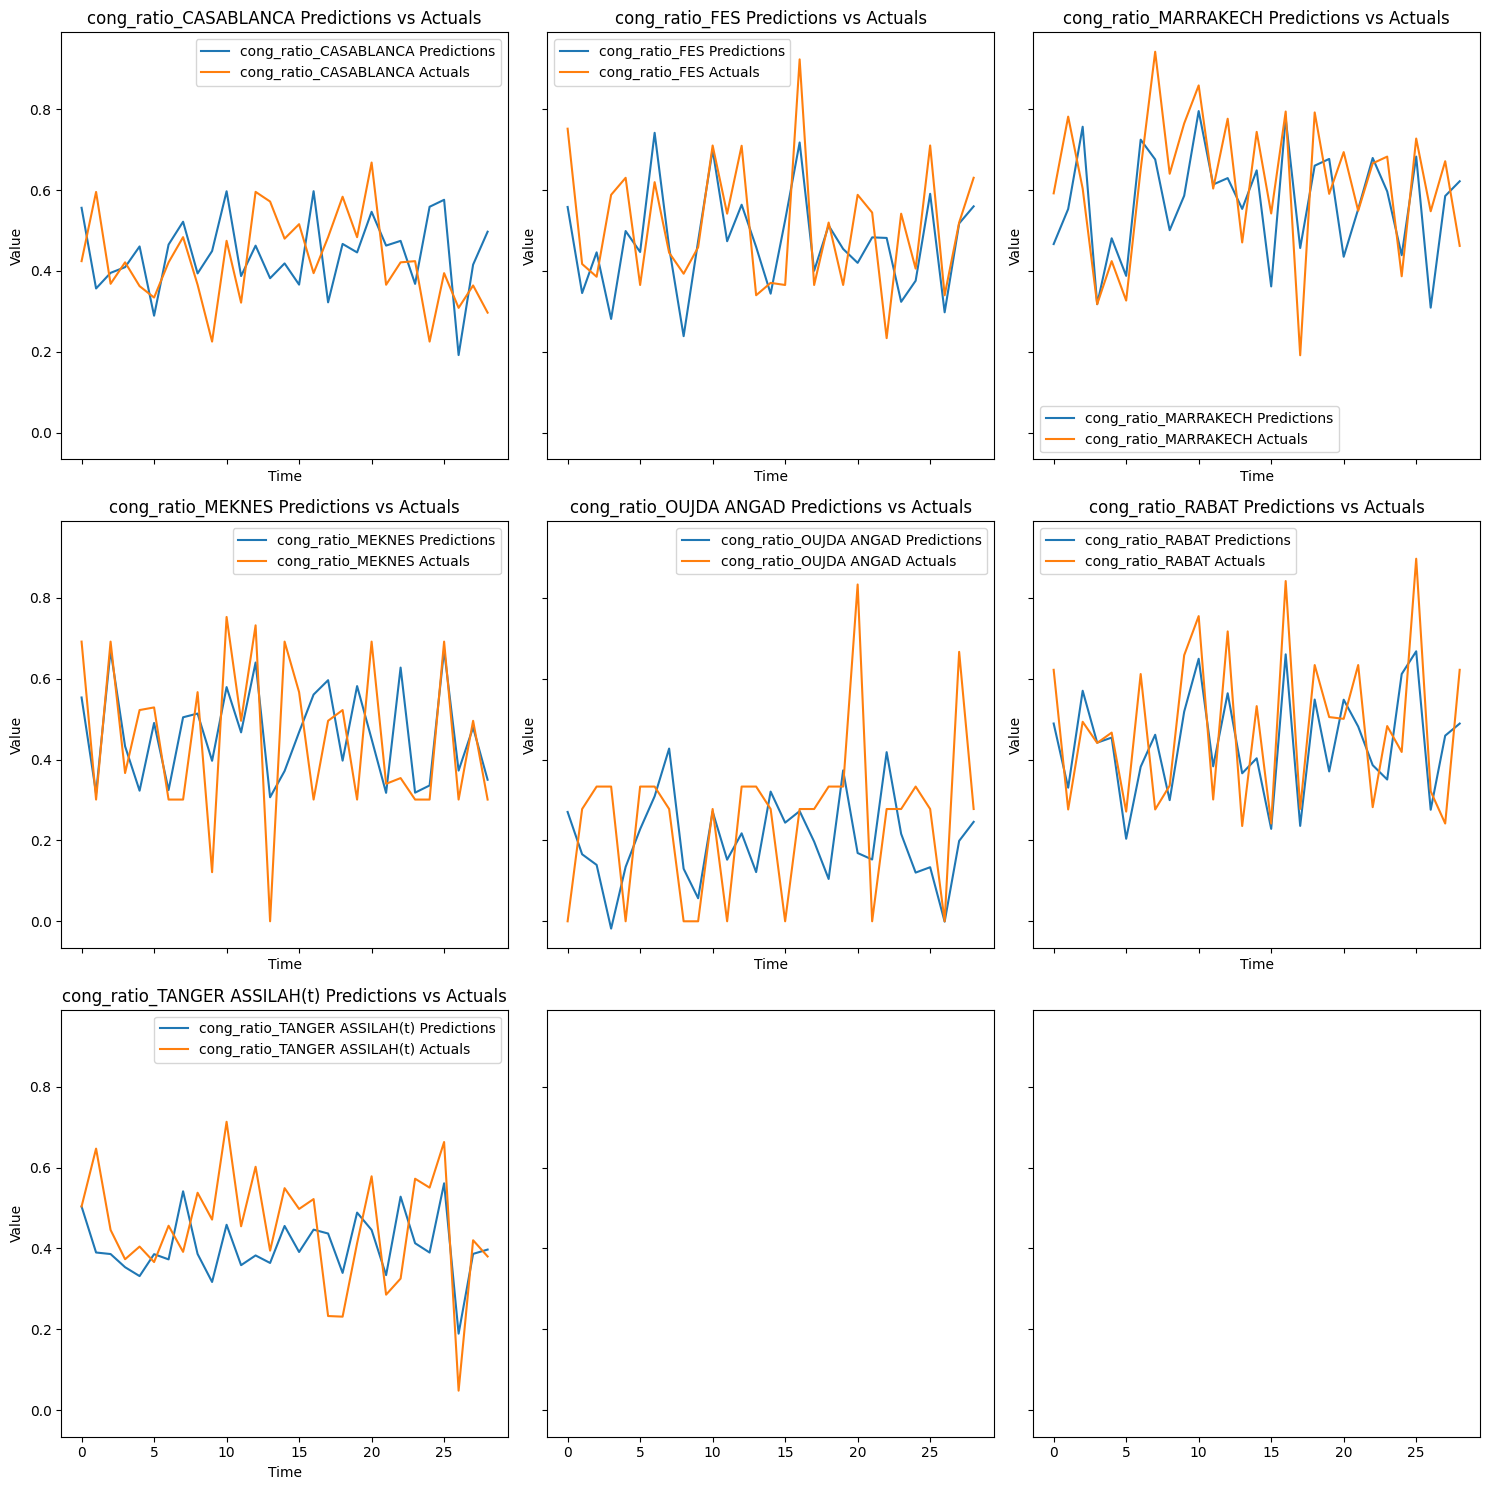

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_selected(model, X, y, start=0, end=100, selected_columns=None, num_plots_per_column=3):
    if selected_columns is None:
        selected_columns = ['cong_ratio_CASABLANCA', 'cong_ratio_FES', 'cong_ratio_MARRAKECH',
                            'cong_ratio_MEKNES', 'cong_ratio_OUJDA ANGAD', 'cong_ratio_RABAT','cong_ratio_TANGER ASSILAH(t)']
    predictions = model.predict(X)

    df_preds = pd.DataFrame(data=predictions, columns=selected_columns)
    df_actuals = pd.DataFrame(data=y, columns=selected_columns)

    num_plots = len(selected_columns)
    num_rows = (num_plots + num_plots_per_column - 1) // num_plots_per_column  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_plots_per_column, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

    for idx, column in enumerate(selected_columns):
        row = idx // num_plots_per_column
        col = idx % num_plots_per_column

        pred = df_preds[column]
        actual = df_actuals[column]

        if num_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if num_plots > 1 else axes

        ax.plot(pred[start:end], label=f'{column} Predictions')
        ax.plot(actual[start:end], label=f'{column} Actuals')
        ax.set_title(f'{column} Predictions vs Actuals')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()

    plt.tight_layout()
    plt.show()

    return pd.concat([df_actuals[start:end].add_suffix(' Actuals'), df_preds[start:end].add_suffix(' Predictions')], axis=1)

results_df = plot_predictions_selected(model2, X_test, y_test, start=0, end=100, selected_columns=[
    'cong_ratio_CASABLANCA', 'cong_ratio_FES', 'cong_ratio_MARRAKECH',
    'cong_ratio_MEKNES', 'cong_ratio_OUJDA ANGAD', 'cong_ratio_RABAT','cong_ratio_TANGER ASSILAH(t)'
])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_pred = model2.predict(X_test)

# Inverse transform the predictions and true values
y_pred = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred))
mae = mean_absolute_error(y_test_inverse, y_pred)
r_squared = r2_score(y_test_inverse, y_pred)

# Print the computed metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
RMSE: 0.02811182914140555
MAE: 0.020301969951628914


In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dropout(0.5))
model2.add(Dense(y_train.shape[1], kernel_regularizer=l2(0.01)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

In [ ]:
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
4/4 - 8s - 2s/step - loss: 0.2646 - val_loss: 0.1846
Epoch 2/50
4/4 - 0s - 95ms/step - loss: 0.2182 - val_loss: 0.1591
Epoch 3/50
4/4 - 0s - 45ms/step - loss: 0.1883 - val_loss: 0.1648
Epoch 4/50
4/4 - 0s - 73ms/step - loss: 0.1851 - val_loss: 0.1564
Epoch 5/50
4/4 - 0s - 42ms/step - loss: 0.1710 - val_loss: 0.1466
Epoch 6/50
4/4 - 0s - 75ms/step - loss: 0.1645 - val_loss: 0.1452
Epoch 7/50
4/4 - 0s - 44ms/step - loss: 0.1604 - val_loss: 0.1416
Epoch 8/50
4/4 - 0s - 48ms/step - loss: 0.1557 - val_loss: 0.1383
Epoch 9/50
4/4 - 0s - 41ms/step - loss: 0.1521 - val_loss: 0.1363
Epoch 10/50
4/4 - 0s - 44ms/step - loss: 0.1460 - val_loss: 0.1329
Epoch 11/50
4/4 - 0s - 72ms/step - loss: 0.1420 - val_loss: 0.1299
Epoch 12/50
4/4 - 0s - 45ms/step - loss: 0.1409 - val_loss: 0.1279
Epoch 13/50
4/4 - 0s - 74ms/step - loss: 0.1376 - val_loss: 0.1246
Epoch 14/50
4/4 - 0s - 72ms/step - loss: 0.1312 - val_loss: 0.1222
Epoch 15/50
4/4 - 0s - 43ms/step - loss: 0.1301 - val_loss: 0.1203
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


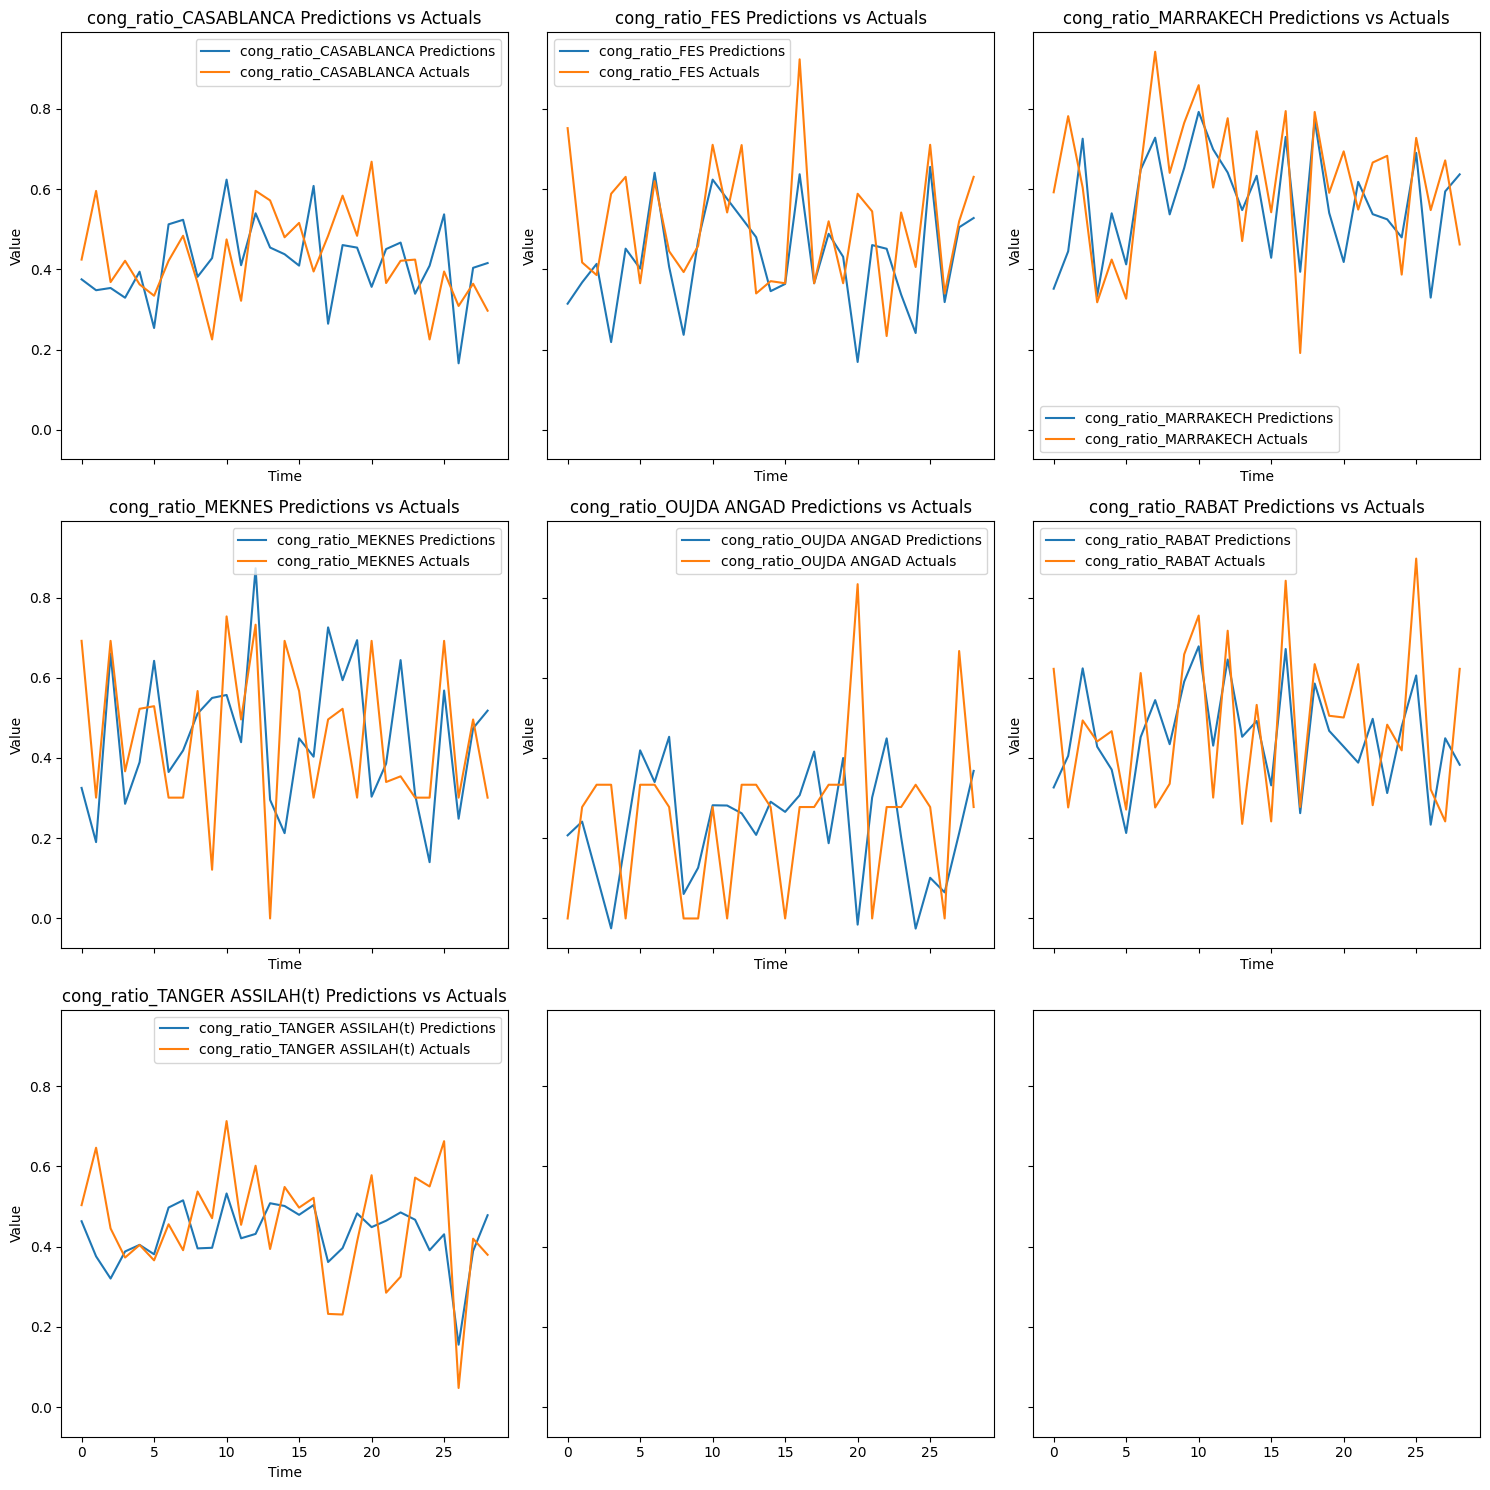

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_selected(model, X, y, start=0, end=100, selected_columns=None, num_plots_per_column=3):
    if selected_columns is None:
        selected_columns = ['cong_ratio_CASABLANCA', 'cong_ratio_FES', 'cong_ratio_MARRAKECH',
                            'cong_ratio_MEKNES', 'cong_ratio_OUJDA ANGAD', 'cong_ratio_RABAT','cong_ratio_TANGER ASSILAH(t)']
    predictions = model.predict(X)

    df_preds = pd.DataFrame(data=predictions, columns=selected_columns)
    df_actuals = pd.DataFrame(data=y, columns=selected_columns)

    num_plots = len(selected_columns)
    num_rows = (num_plots + num_plots_per_column - 1) // num_plots_per_column  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_plots_per_column, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

    for idx, column in enumerate(selected_columns):
        row = idx // num_plots_per_column
        col = idx % num_plots_per_column

        pred = df_preds[column]
        actual = df_actuals[column]

        if num_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col] if num_plots > 1 else axes

        ax.plot(pred[start:end], label=f'{column} Predictions')
        ax.plot(actual[start:end], label=f'{column} Actuals')
        ax.set_title(f'{column} Predictions vs Actuals')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()

    plt.tight_layout()
    plt.show()

    return pd.concat([df_actuals[start:end].add_suffix(' Actuals'), df_preds[start:end].add_suffix(' Predictions')], axis=1)

results_df = plot_predictions_selected(model, X_test, y_test, start=0, end=100, selected_columns=[
    'cong_ratio_CASABLANCA', 'cong_ratio_FES', 'cong_ratio_MARRAKECH',
    'cong_ratio_MEKNES', 'cong_ratio_OUJDA ANGAD', 'cong_ratio_RABAT','cong_ratio_TANGER ASSILAH(t)'
])

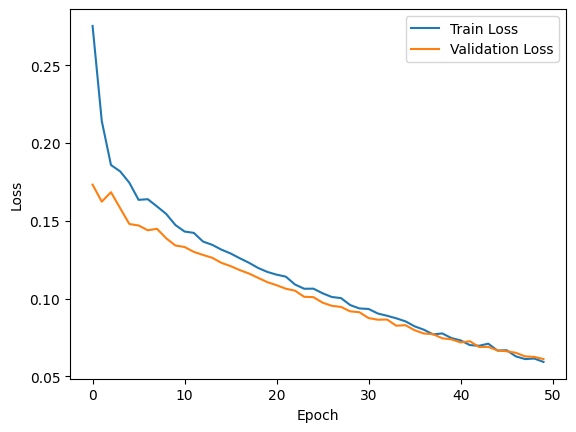

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_pred = model2.predict(X_test)

# Inverse transform the predictions and true values
y_pred = target_scaler.inverse_transform(y_pred)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred))
mae = mean_absolute_error(y_test_inverse, y_pred)
r_squared = r2_score(y_test_inverse, y_pred)

# Print the computed metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE: 0.02873585295471077
MAE: 0.02028621244174162


In [ ]:
model2.save('bidirectional_lstm_model.h5')

In [ ]:
import numpy as np
import pandas as pd

def prepare_forecast_input(data, n_in=20):
    if len(data) < n_in:
        raise ValueError("Insufficient data to prepare forecast input")
    last_values = data[-n_in:]
    forecast_input = np.reshape(last_values, (1, n_in, data.shape[1]))
    return forecast_input

def forecast_lstm_multiple_steps(model, data_pivot, feature_columns, target_columns, window_size, forecast_steps):
    # Prepare initial forecast input
    forecast_input_data = data_pivot[feature_columns].values
    forecast_input = prepare_forecast_input(forecast_input_data, n_in=window_size)

    # Initialize list to store all predictions and dates
    all_predictions = []
    forecast_dates = []

    # Extract the last date from the index
    last_date = data_pivot.index[-1]

    for step in range(forecast_steps):
        # Predict the next values
        forecast = model.predict(forecast_input)

        # Store the predictions
        all_predictions.append(forecast[0])

        # Generate the forecast date
        forecast_dates.append(last_date + pd.DateOffset(days=step + 1))

        # Update the forecast input with the new predictions
        forecast_input_data = np.roll(forecast_input_data, shift=-1, axis=0)

        # Only include the feature columns in the input data for the next prediction
        forecast_input_data[-1, :len(target_columns)] = forecast[0]

        # Prepare the new input for the next prediction
        forecast_input = prepare_forecast_input(forecast_input_data, n_in=window_size)

    # Convert predictions to a DataFrame and include dates
    forecast_df = pd.DataFrame(np.array(all_predictions), columns=target_columns, index=forecast_dates)

    return forecast_df

# Parameters
forecast_steps = 30  # Number of days to forecast
window_size = 20  # Window size for LSTM input
feature_columns = [col for col in supervised_data.columns if col not in [
    'cong_ratio_CASABLANCA(t)', 'cong_ratio_FES(t)',
    'cong_ratio_MARRAKECH(t)', 'cong_ratio_MEKNES(t)',
    'cong_ratio_OUJDA ANGAD(t)', 'cong_ratio_RABAT(t)', 'cong_ratio_TANGER ASSILAH(t)'
]]
target_columns = [
    'cong_ratio_CASABLANCA(t)', 'cong_ratio_FES(t)',
    'cong_ratio_MARRAKECH(t)', 'cong_ratio_MEKNES(t)',
    'cong_ratio_OUJDA ANGAD(t)', 'cong_ratio_RABAT(t)', 'cong_ratio_TANGER ASSILAH(t)'
]

# Forecast future values
forecast_df = forecast_lstm_multiple_steps(model2, supervised_data, feature_columns, target_columns, window_size, forecast_steps)

print("Forecasted values:")
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

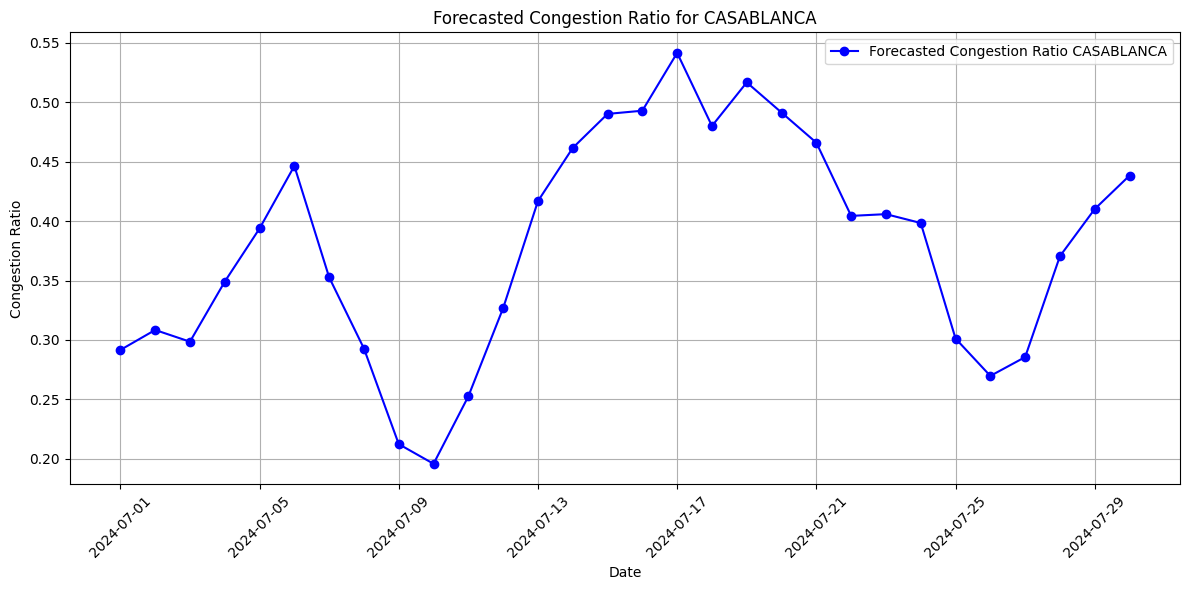

In [ ]:
import matplotlib.pyplot as plt

# Extract the forecasted values for 'cong_ratio_CASABLANCA(t)'
forecast_casablanca = forecast_df['cong_ratio_CASABLANCA(t)']

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_casablanca.index, forecast_casablanca.values, marker='o', linestyle='-', color='b', label='Forecasted Congestion Ratio CASABLANCA')
plt.title('Forecasted Congestion Ratio for CASABLANCA')
plt.xlabel('Date')
plt.ylabel('Congestion Ratio')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()